In [1]:
%matplotlib inline


# Ensemble sifting
This tutorial introduces the ensemble sift. This is a noise-assisted approach
to sifting which overcomes some of the problems in the original sift.


Lets make a simulated signal to get started. Here we generate two bursts of
oscillations and some dynamic noise.



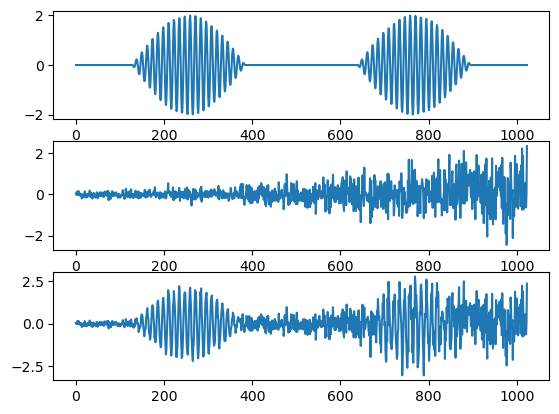

In [2]:
import emd
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 512
seconds = 2
time_vect = np.linspace(0, seconds, seconds*sample_rate)

# Create an amplitude modulated burst
am = -np.cos(2*np.pi*1*time_vect) * 2
am[am < 0] = 0
burst = am*np.sin(2*np.pi*42*time_vect)

# Create some noise with increasing amplitude
am = np.linspace(0, 1, sample_rate*seconds)**2 + .1
np.random.seed(42)
n = am * np.random.randn(sample_rate*seconds,)

# Signal is burst + noise
x = burst + n

# Quick summary figure
plt.figure()
plt.subplot(311)
plt.plot(burst)
plt.subplot(312)
plt.plot(n)
plt.subplot(313)
plt.plot(x)

The standard sifting methods do not perform well on this signal. Here we run
``emd.sift.sift`` and plot the result.



<AxesSubplot:xlabel='Time (samples)'>

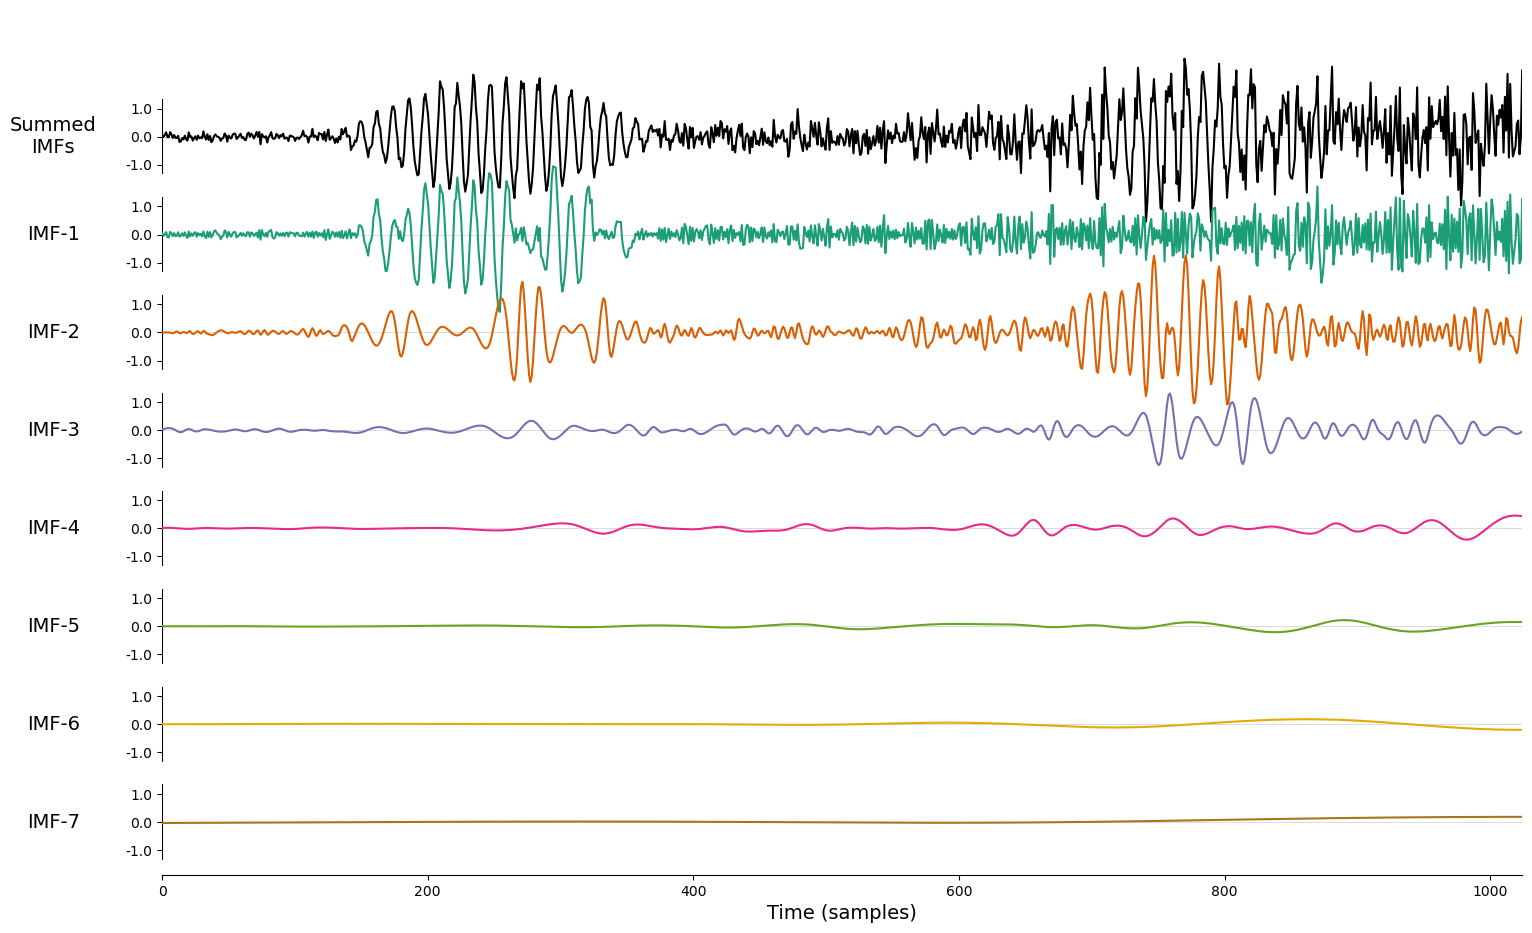

In [3]:
imf_opts = {'sd_thresh': 0.05}
imf = emd.sift.sift(burst+n, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf)

We can see that the 42Hz bursting activity is split across two or three IMFs.
The first burst is split between IMFs 1 and 2 whereas the second burst is
split between IMFs 2 and 3. As these events are all the same frequency, we
want them to be in the the IMF to make subsequent spectrum analysis easier.

The problem in this case is the dynamic noise. The peaks and troughs of the
first burst are only slightly distorted by the additive noise (whose variance
is low in the first half of the signal). Therefore most of the first burst
appears in the first IMF with a small segment in the second IMF.

In contrast, the high variance noise under the second burst is large enough
to consitute a feature in itself. The second burst is completely pushed out
of IMF1.

The combined problems of noise sensitivity and transient signals can lead to
poor sift results.



## Noise-assisted sifting



One solution to these issues is to try and normalise the amount of noise
through a signal by adding a small amount of white noise to the signal before
sifting. We do this many times, creating an ensemble of sift processes each
with a separate white noise added. The final set of IMFs is taken to be the
average across the whole ensemble.

This might seem like an odd solution. It relies on the effect of the additive
white noise cancelling out across the whole ensemble, whilst the true signal
(which is present across the whole ensemble) should survive the averaging.

Here we try this out by extracting out first IMF five times. Once without
noise and four times with noise.



In [4]:
imf = np.zeros((x.shape[0], 5))

# Standard sift
imf[:, 0] = emd.sift.get_next_imf(x, **imf_opts)[0][:, 0]

# Additive noise sifts
noise_variance = .25
for ii in range(4):
    imf[:, ii+1] = emd.sift.get_next_imf(x + np.random.randn(x.shape[0],)*noise_variance, **imf_opts)[0][:, 0]

Next we plot our IMF from the standard sift and the four noise-added ensemble sifts



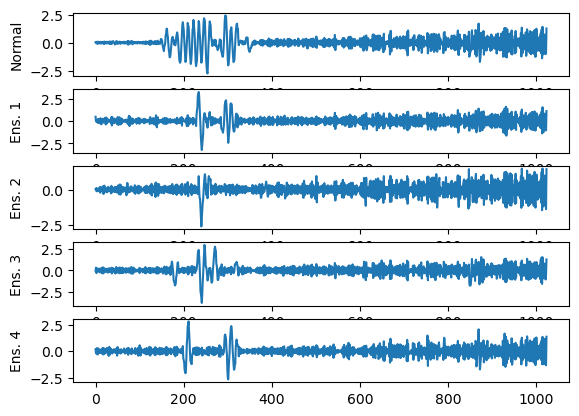

In [5]:
plt.figure()
for ii in range(5):
    plt.subplot(5, 1, ii+1)
    plt.plot(imf[:, ii])

    if ii == 0:
        plt.ylabel('Normal')
    else:
        plt.ylabel('Ens. {0}'.format(ii))

We can see that the first burst appears clearly in the first IMF for the
standard sift as before. This burst is suppressed in each of the ensembles.
Some of it remains but crucially different parts of the signal are attenuated
in each of the four ensembles.

The average of these four noise-added signals shows a strong suppression of
the first burst.



Text(0, 0.5, 'Ens. Avg')

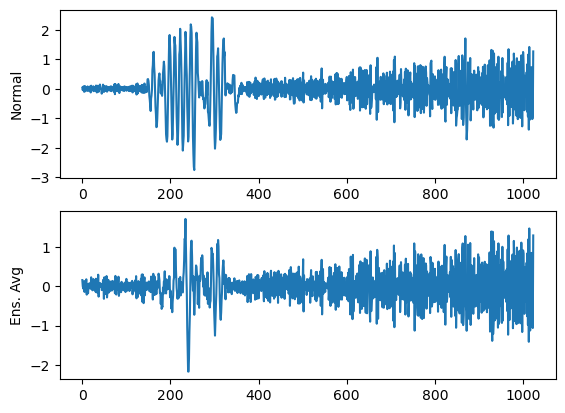

In [6]:
plt.figure()
plt.subplot(211)
plt.plot(imf[:, 0])
plt.ylabel('Normal')
plt.subplot(212)
plt.plot(imf[:, 1:].mean(axis=1))
plt.ylabel('Ens. Avg')

Some of the first burst still remains. We can increase the attenuation by
increasing the variance of the added noise.

Here, we run the ensemble of four again but we increase the ``noise_variance`` from `0.25` to `1`.



In [7]:
imf = np.zeros((x.shape[0], 5))

# Standard sift
imf[:, 0] = emd.sift.get_next_imf(x, **imf_opts)[0][:, 0]

# Additive noise sifts
noise_variance = 1
for ii in range(4):
    imf[:, ii+1] = emd.sift.get_next_imf(x + np.random.randn(x.shape[0],)*noise_variance, **imf_opts)[0][:, 0]

If we plot the average of this new ensemble, we can see that the first burst
is now completely removed from the first IMF.



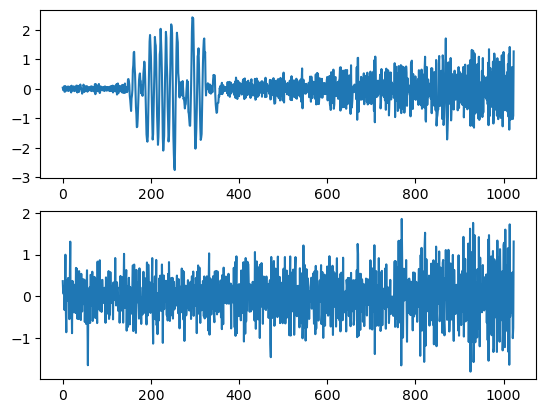

In [8]:
plt.figure()
plt.subplot(211)
plt.plot(imf[:, 0])
plt.subplot(212)
plt.plot(imf[:, 1:].mean(axis=1))

## Ensemble Sifting



This process is implemented for a whole sifting run in
``emd.sift.ensemble_sift``. This function works much like ``emd.sift.sift``
with a few extra options for controlling the noise ensembles.

* `nensembles` defines the number of parallel sifts to compute
* `ensemble_noise` defines the noise variance relative to the standard deviation of the input signal
* `nprocesses` allow for parallel processing of the ensembles to speed up computation

Next, we call ``emd.sift.ensemble_sift`` to run through a whole sift of our signal.

Note that it is ofen a good idea to limit the total number of IMFs in an
ensemble_sift. If we allow the sift to compute all possible IMFs then there
is a chance that some processes in the ensemble might complete with one more
or one less IMF than the others - this will break the averaging so here, we
only compute the first five IMFs.



First, we compute the sift with `2` ensembles.



<AxesSubplot:xlabel='Time (samples)'>

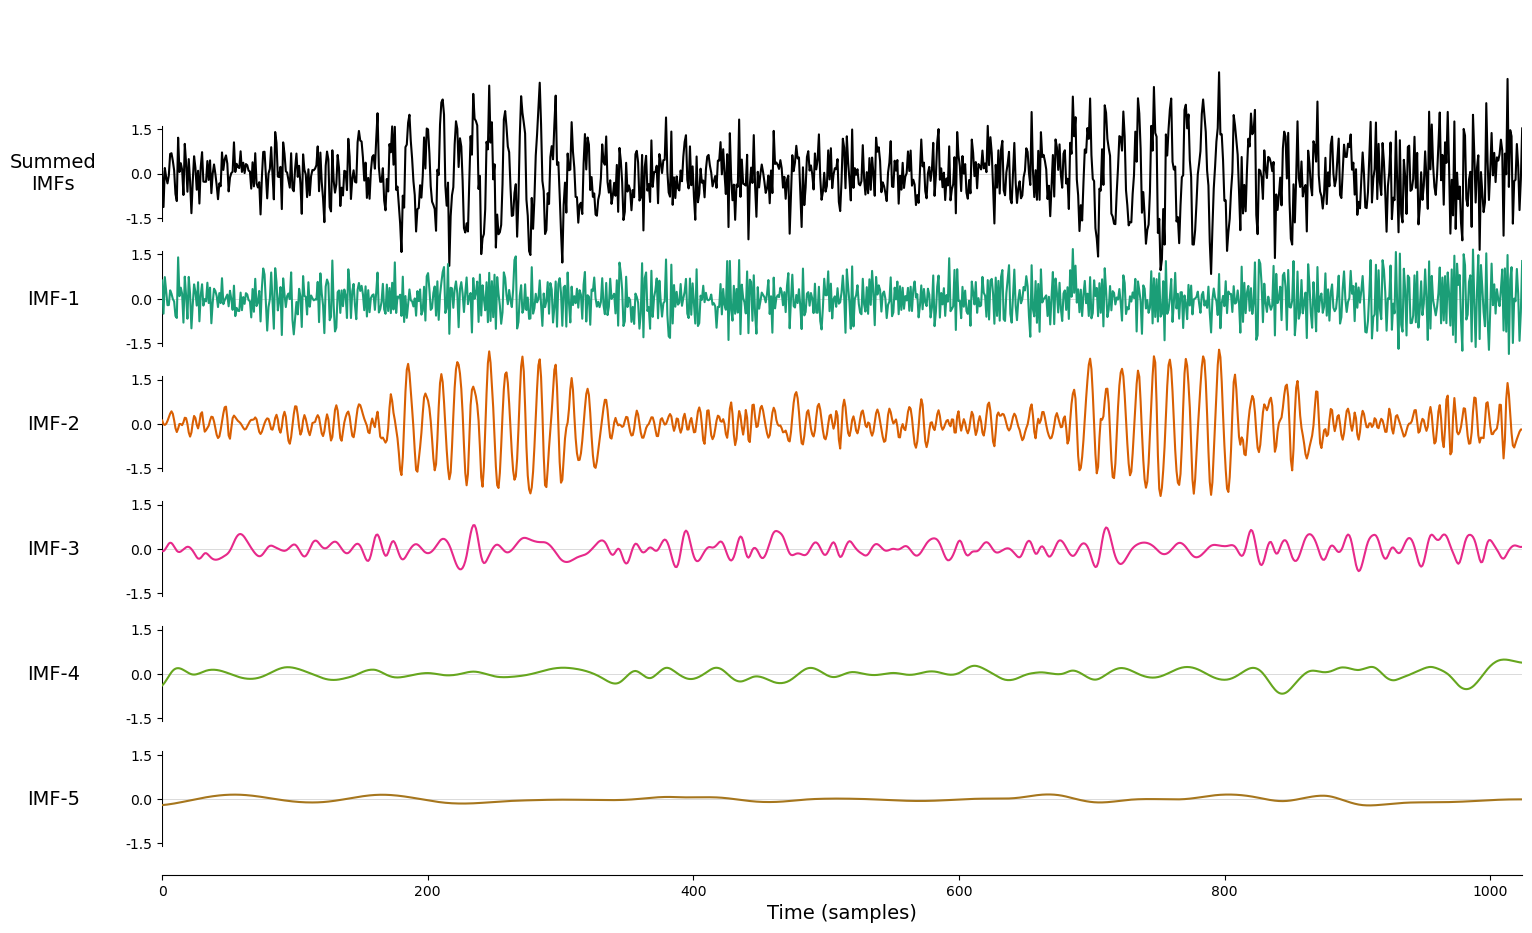

In [9]:
imf = emd.sift.ensemble_sift(burst+n, max_imfs=5, nensembles=2, nprocesses=6, ensemble_noise=1, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf)

This does a reasonable job. Certainly better than the standard sift we ran at
the start of the tutorial. There is still some mixing of signals visible
though. To help with this we next compute the ensemble sift with four
separate noise added sifts.



<AxesSubplot:xlabel='Time (samples)'>

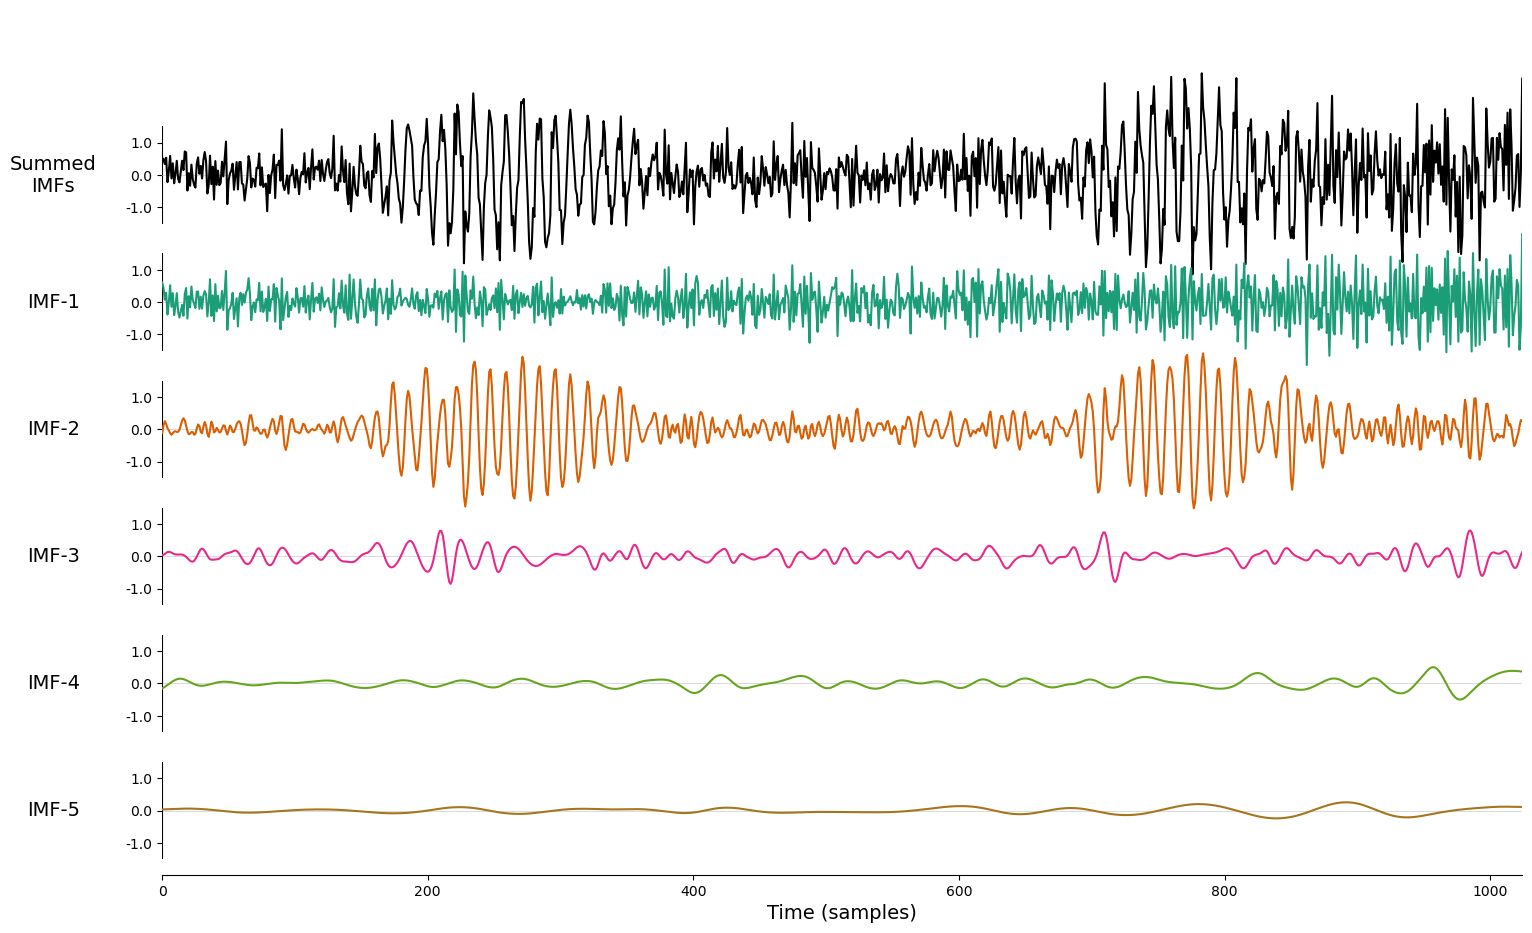

In [10]:
imf = emd.sift.ensemble_sift(burst+n, max_imfs=5, nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf)

This is better again but still could be improved. Finally, we run a sift with
an ensemble of 24 separate sifts.



<AxesSubplot:xlabel='Time (samples)'>

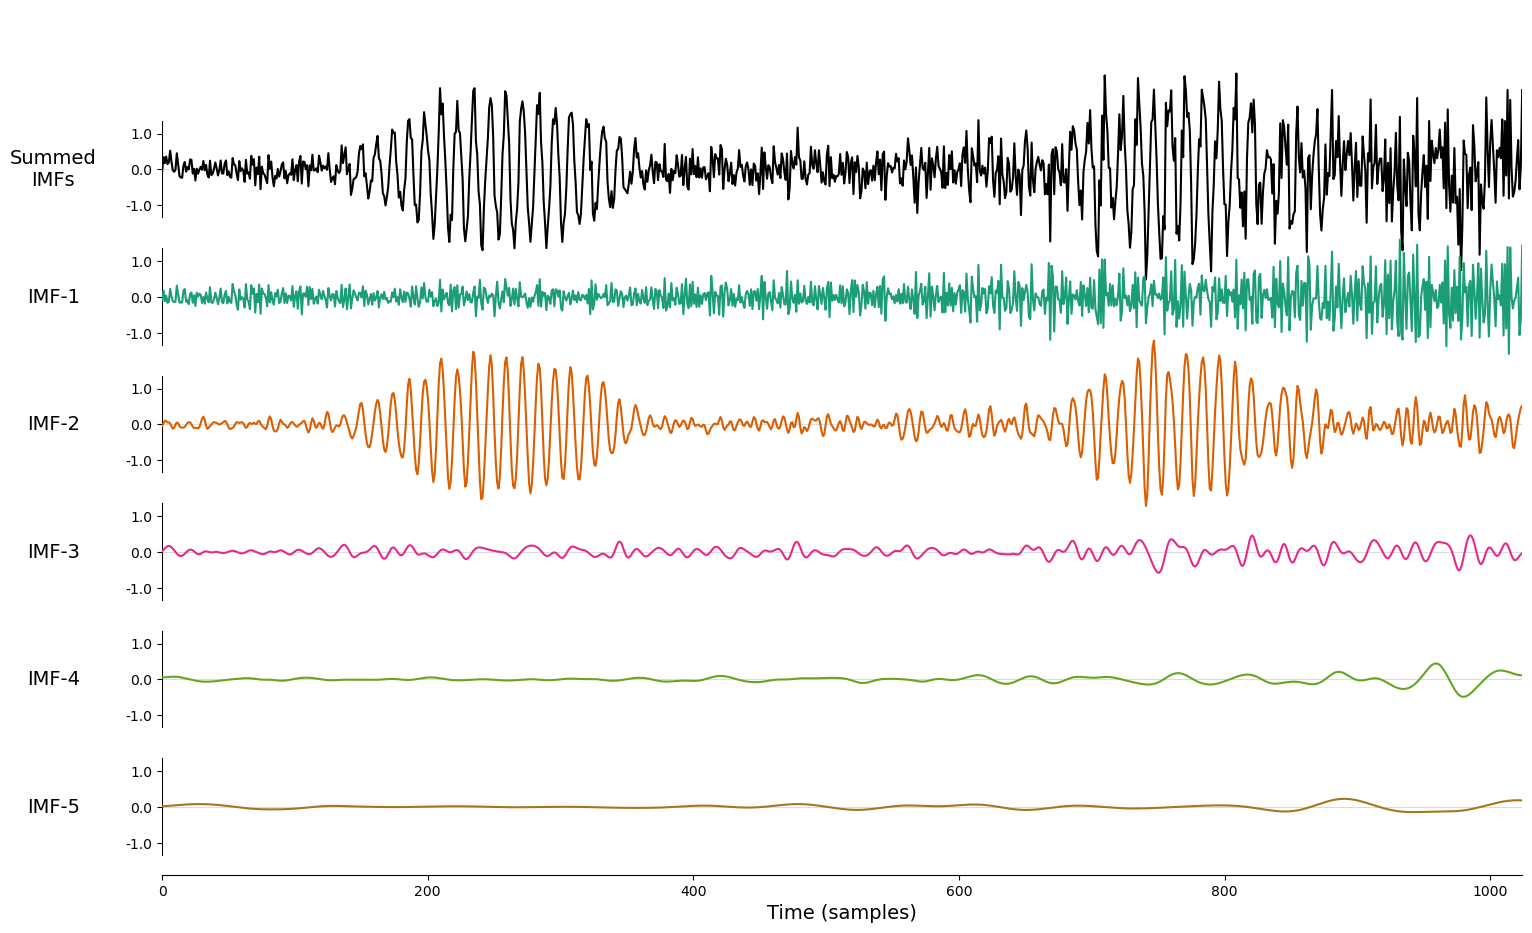

In [11]:
imf = emd.sift.ensemble_sift(burst+n, max_imfs=5, nensembles=24, nprocesses=6, ensemble_noise=1, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf)

This does a good job. Both bursts are clearly recovered with smooth amplitude
modulations and the noise in the first IMF shows the smooth increase in
variance that we defined at the start.



## Further Reading & References



Wu, Z., & Huang, N. E. (2009). Ensemble Empirical Mode Decomposition:
A Noise-Assisted Data Analysis Method. Advances in Adaptive Data Analysis, 1(1), 1–41. 
https://doi.org/10.1142/s1793536909000047

Wu, Z., & Huang, N. E. (2004). A study of the characteristics of
white noise using the empirical mode decomposition method. Proceedings of
the Royal Society of London. Series A: Mathematical, Physical and
Engineering Sciences, 460(2046), 1597–1611.
https://doi.org/10.1098/rspa.2003.1221

